In [1]:
%%capture capt
!pip install pywaffle

In [2]:
%%capture capt
import numpy as np
from matplotlib.ticker import PercentFormatter
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pywaffle import Waffle
import math
import seaborn as sns

## Import data

In [3]:
patient = pd.read_csv("../data/profil_patient_cluster.csv")
patient_custom = pd.read_csv('../data/profil_patient_cluster_custom.csv')

## Preprocessing

In [4]:
def preprocessing(patient):
    patient['CHOC'] = patient['CHOC'].astype(int)
    patient['y_nais'] = 2016 - patient['y_nais']
    #Nb_jours_moyen=Nombre de jours hospitalisé / Nombre de séjours
    #Moyenne empirique du nombre de jours hospitalisé
    patient['Nb_jours_moyen'] = patient['Nb_jours_sej'] / patient['Nb_hospit']
    patient = patient.rename(columns={'y_nais':'age'})
    patient['cluster'] = [1+np.argmax(patient.loc[:, 'cluster1':'cluster20'].iloc[i]) for i in range(len(patient))]
    
    return patient

In [5]:
patient = preprocessing(patient)
patient_custom = preprocessing(patient_custom)

In [6]:
patient.head(3)

,CODE_PATIENT,date_h0,age,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,...,cluster14,cluster15,cluster16,cluster17,cluster18,cluster19,cluster20,p_soins,Nb_jours_moyen,cluster
0,P0,2011-11-22,67,11,1,NaN,False,2596,9,0,...,0,0,0,0,0,0,0,"05K051,05M042,05M16T,05M09T,05M092,05C191,05M2...",2.555556,7
1,P6,2013-12-05,87,14,2,2015-03,True,456,8,0,...,0,0,0,1,0,0,0,"02C05J,02C05J,05M093,04M132,05C222,23M103,04M0...",6.375000,17
2,P8,2015-07-02,49,54,2,2015-08,True,41,3,1,...,0,0,0,0,1,0,0,"11M041,06C194",14.333333,18


# Visualisation des clusters

### Distribution de population par cluster

In [7]:
def pct_cluster(df, title):
    data=df.groupby("cluster").count()["CODE_PATIENT"].sort_values(ascending=False)
    plt.figure(
        FigureClass=Waffle,
        rows=15,
        columns=20,
        title={
            'label': 'Segmentation population par cluster - metrique: ' + title,
            'loc': 'center',
            'fontdict': {
                'fontsize': 10
            }},
        values=data,
        labels=[f"{k} ({int(v / sum(data) * 100)}%)" for k, v in data.items()],  # Legend would not be created without this line
        legend={'title': 'Clusters', 'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'ncol': 2,},
        cmap_name="tab20b"
    )
    plt.plot()

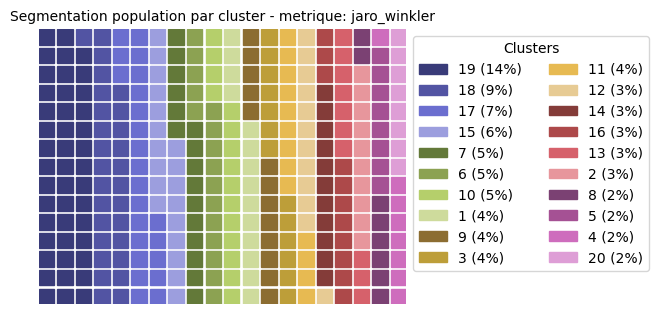

In [8]:
pct_cluster(patient, 'jaro_winkler')

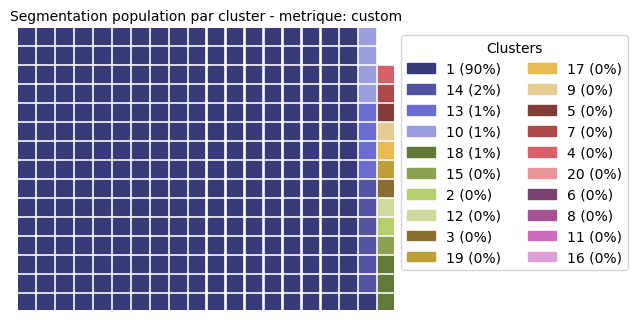

In [15]:
pct_cluster(patient_custom, 'custom')

### Distribution des ages

In [10]:
def hist_age(df, title):
    nb_clusters = len(np.unique(patient.cluster))
    fig, axs = plt.subplots(math.ceil(nb_clusters//4), 4, figsize=(15, 4*math.ceil(nb_clusters//4)))
    i = 1
    for ax_i in axs:
        for ax in ax_i:
            sns.histplot(data=df.loc[df.cluster == i].age, kde=True, ax=ax)
            ax.axvline(x=df.age.median(), color='r', label='median')
            ax.axvline(x=df.age.quantile(.25), color='r', linestyle='--', label='q0.25')
            ax.axvline(x=df.age.quantile(.75), color='r', linestyle='-.', label='q0.75')
            ax.set_title('cluster ' + str(i))
            ax.set_xlim([18, 105])
            ax.set_xlabel('')
            i += 1
    
    fig.suptitle("Distribution des ages par cluster - metrique: " + str(title))
    #fig.legend(loc='best')

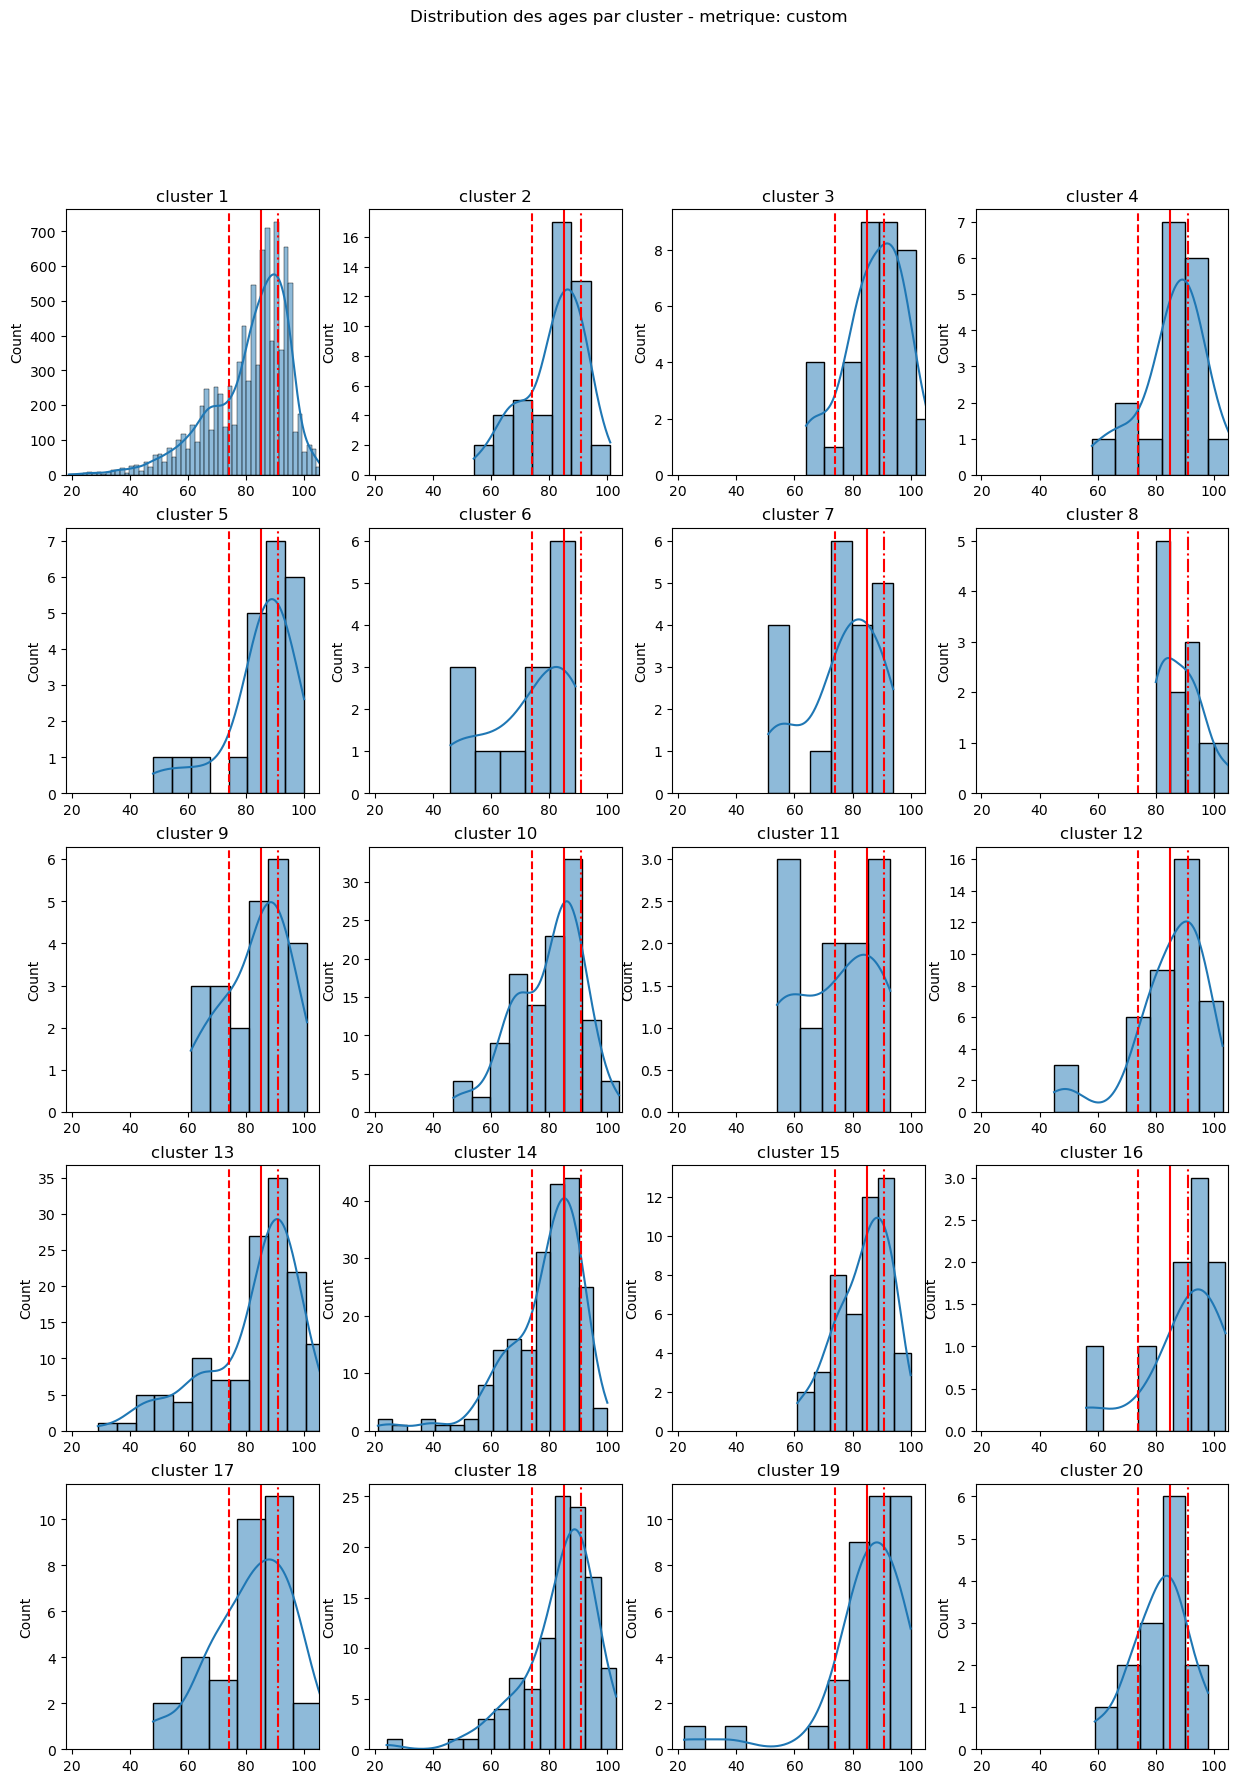

In [12]:
hist_age(patient_custom, 'custom')

### Longueur des parcours de soins

In [13]:
def len_p_soins(df, title):
    nb_clusters = len(np.unique(patient.cluster))
    labels = range(1, nb_clusters+1)
    counts = []
    for i in range(1, nb_clusters+1):
        df_cluster_i = df.loc[df.cluster == i]
        len_soins = [x.count(",")+1 for x in df_cluster_i.p_soins]
        counts.append(np.median(len_soins))
    plt.bar(labels, counts, align='center', color = 'black')
    plt.gca().set_xticks(labels)
    #plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title('Longueur médiane des parcours de soins, metrique: ' + title)
    plt.xlabel("Cluster")
    plt.show()

In [14]:
len_p_soins(patient_custom, 'custom')

AttributeError: 'float' object has no attribute 'count'